In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
set_global_seed(42)
data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
data_path_2 = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"
data_paths = [data_path_1, data_path_2]
# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
labels = SAT_CLASSES_ACCURACY
info_to_keep = ["event_name", "rt"]
whole_epoch = True
subset_cond = None
add_negative = True
skip_samples = 0

In [3]:
norm_fn = norm_mad_zscore
train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    # Replace with startjittertransform
    # transform=Compose([FixedLengthCropTransform(), ReverseTimeTransform()]),
    # transform=Compose([StartJitterTransform(62)]),
    # transform=Compose([StartJitterTransform(62), FixedLengthCropTransform()]),
    skip_samples=skip_samples,
    concat_probability=1.0,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    # transform=Compose([FixedLengthCropTransform()]),
    skip_samples=skip_samples,
)
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    # transform=Compose([FixedLengthCropTransform()]),
    skip_samples=skip_samples,
)

tensor(227)
634


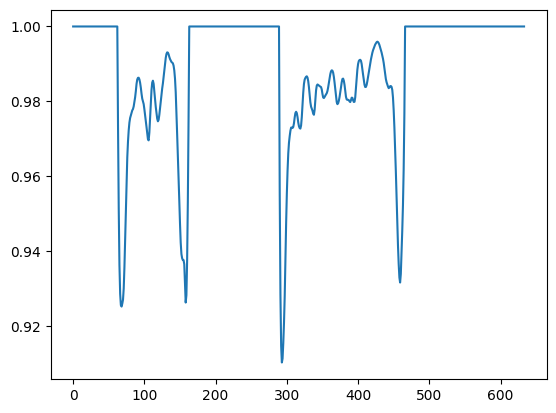

In [25]:
import matplotlib.pyplot as plt
data = train_data.__getitem__(1)
print(data[0].shape[0])
# plt.plot(data[0][:400, 0])
plt.plot(data[1][:700, 0])

In [ ]:
def base_mamba():
    embed_dim = 64
    out_channels = 128
    base_cnn = nn.Sequential(
        nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=50,
            stride=1,
            padding='same',
        ),
        nn.ReLU(),
    )
    model_kwargs = {
        "embed_dim": embed_dim,
        "mamba_dim": out_channels,
        "n_channels": 19,
        "n_classes": len(labels),
        "n_mamba_layers": 5,
        "cnn_module": base_cnn,
        "dropout": 0.1,
    }
    model = ConfigurableMamba(**model_kwargs)
    return model

In [10]:
def parallel_mamba():
    embed_dim = 64
    out_channels = 128
    parallel_cnn_modules = [
        nn.Conv1d(in_channels=embed_dim, out_channels=32, kernel_size=5, padding='same', device=DEVICE),
        nn.Conv1d(in_channels=embed_dim, out_channels=32, kernel_size=15, padding='same', device=DEVICE),
        nn.Conv1d(in_channels=embed_dim, out_channels=32, kernel_size=26, padding='same', device=DEVICE),
        nn.Conv1d(in_channels=embed_dim, out_channels=32, kernel_size=48, padding='same', device=DEVICE),
    ]
    model_kwargs = {
        "embed_dim": embed_dim,
        "mamba_dim": out_channels,
        "n_channels": 19,
        "n_classes": len(labels),
        "n_mamba_layers": 5,
        "parallel_cnn_modules": parallel_cnn_modules,
        "dropout": 0.1,
    }
    model = ConfigurableMamba(**model_kwargs)
    return model

model = parallel_mamba()

train_and_test(
    model,
    train_data,
    test_data,
    val_data,
    logs_path=Path("../logs/"),
    workers=8,
    batch_size=64,
    labels=labels,
    lr=0.0001,
    # label_smoothing=0.1,
    # weight_decay=0.0001,
    do_spectral_decoupling=False,
    use_class_weights=False,
    class_weights=class_weights,
    whole_epoch=True,
    epochs=100,
)

  0%|          | 0/323 [00:00<?, ? batch/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

  0%|          | 0/323 [00:00<?, ? batch/s]

[{'KLDivLoss': 1.0561292171478271}]

In [ ]:
def twostream_cnn():
    # TODO: Rethink whatever this is, I think putting features into channel/time dimension is not good, channels are of course a feature as well but idk
    embed_dim = 64
    out_channels = 128
    space_conv = nn.Sequential(
        nn.Conv2d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=(1, 1),  # Convolution over the channel dimension (n_channels)
            stride=1,
            padding=0,
        ),
        nn.ReLU(),
    )

    time_conv = nn.Sequential(
        nn.Conv2d(
            in_channels=1,
            out_channels=embed_dim,
            kernel_size=(50, 1),
            stride=1,
            padding=0,
        ),
        nn.ReLU(),
    )

    model_kwargs = {
        "embed_dim": embed_dim,
        "mamba_dim": out_channels,
        "n_channels": 19,
        "n_classes": len(labels),
        "n_mamba_layers": 5,
        "space_cnn_module": space_conv,
        "time_cnn_module": time_conv,
        "dropout": 0.1,
    }
    model = ConfigurableMamba(**model_kwargs)
    return model